In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry
import feature_extraction as fe

In [3]:
ee.Authenticate()
ee.Initialize()

In [4]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B2', 'B3', 'B4']

In [5]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [6]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2020-01-01', '2021-01-30')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
    .map(mask_s2_clouds)
)

In [7]:
# geometry_sd = ee.Geometry.Polygon(
#     [[[-70.08239177868184,18.412691062890588],
#       [-69.70542339489278,18.412691062890588],
#       [-69.70542339489278,18.610630760258402],
#       [-70.08239177868184,18.610630760258402]]])

geometry_sd = ee.Geometry.Polygon(
    [[[-70.05239177868184,18.422691062890588],
      [-69.75542339489278,18.422691062890588],
      [-69.75542339489278,18.600630760258402],
      [-70.05239177868184,18.600630760258402]]])

sd_cutout = dataset.median().clip(geometry_sd).select(FEATURES)

In [8]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(-69.929611, 18.483402, 12)
m.add_layer(sd_cutout, visualization, 'RGB')
m

Map(center=[18.483402, -69.929611], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [9]:
# Print dimensions of sd_cutout image
print(sd_cutout.getInfo())

{'type': 'Image', 'bands': [{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'dimensions': [2, 3], 'origin': [-71, 17], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'dimensions': [2, 3], 'origin': [-71, 17], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': 0, 'max': 6.553500175476074}, 'dimensions': [2, 3], 'origin': [-71, 17], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:footprint': {'type': 'Polygon', 'coordinates': [[[-70.05239177868184, 18.42269106289059], [-69.75542339489277, 18.42269106289059], [-69.75542339489277, 18.6006307602584], [-70.05239177868184, 18.6006307602584], [-70.05239177868184, 18.42269106289059]]]}}}


In [10]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_files = []

output_path = os.path.join(temp_dir, "santo_domingo_img_0.tif")
if not os.path.exists(output_path):

    # Create dataframe to store image coordinates
    image_coords = pd.DataFrame(columns=["file_name", "x", "y"])


    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_sd, num_parts=30)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"santo_domingo_img_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(sd_cutout, filename=output_filename, region=geojson_geometry, scale=1)
        print(f"Exporting {output_filename}...")

        new_row = pd.DataFrame([{"file_name": output_filename, "x": subgeometry.centroid.x, "y": subgeometry.centroid.y}])

        # Concatenate the new row to the existing DataFrame
        image_coords = pd.concat([image_coords, new_row], ignore_index=True)

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"santo_domingo_img_{i}.tif") for i in range(len(subgeometries))]
else:
    print("Found existing santo_domingo_img_#.tif file. Using that instead.")

Found existing santo_domingo_img_#.tif file. Using that instead.


In [ ]:
from keras.preprocessing import image

In [11]:
from keras.applications.vgg16 import VGG16 as vgg
from keras.applications.vgg16 import preprocess_input as vgg_p

In [68]:
from tensorflow.keras.applications import EfficientNetB7 as effnet
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_p

In [70]:
image_list = []

for img_path in os.listdir("temporary"):
    print(img_path)
    with rasterio.open(os.path.join("temporary", img_path)) as src:

        img = src.read([1, 2, 3])  # Read the first three channels (RGB)
        img = np.transpose(img, (1, 2, 0))  # Transpose to (height, width, channels)
        
        # Normalize to 0-255 and convert to uint8
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)

        # Convert to Pillow image
        pil_img = image.array_to_img(img, scale=False)
        pil_img = pil_img.resize((1103, 662))  # Resize the image to the desired size
        
        image_list.append(pil_img)

santo_domingo_img_0.tif
santo_domingo_img_1.tif
santo_domingo_img_10.tif
santo_domingo_img_100.tif
santo_domingo_img_101.tif
santo_domingo_img_102.tif
santo_domingo_img_103.tif
santo_domingo_img_104.tif
santo_domingo_img_105.tif
santo_domingo_img_106.tif
santo_domingo_img_107.tif
santo_domingo_img_108.tif
santo_domingo_img_109.tif
santo_domingo_img_11.tif
santo_domingo_img_110.tif
santo_domingo_img_111.tif
santo_domingo_img_112.tif
santo_domingo_img_113.tif
santo_domingo_img_114.tif
santo_domingo_img_115.tif
santo_domingo_img_116.tif
santo_domingo_img_117.tif
santo_domingo_img_118.tif
santo_domingo_img_119.tif
santo_domingo_img_12.tif
santo_domingo_img_120.tif
santo_domingo_img_121.tif
santo_domingo_img_122.tif
santo_domingo_img_123.tif
santo_domingo_img_124.tif
santo_domingo_img_125.tif
santo_domingo_img_126.tif
santo_domingo_img_127.tif
santo_domingo_img_128.tif
santo_domingo_img_129.tif
santo_domingo_img_13.tif
santo_domingo_img_130.tif
santo_domingo_img_131.tif
santo_domingo_img_13

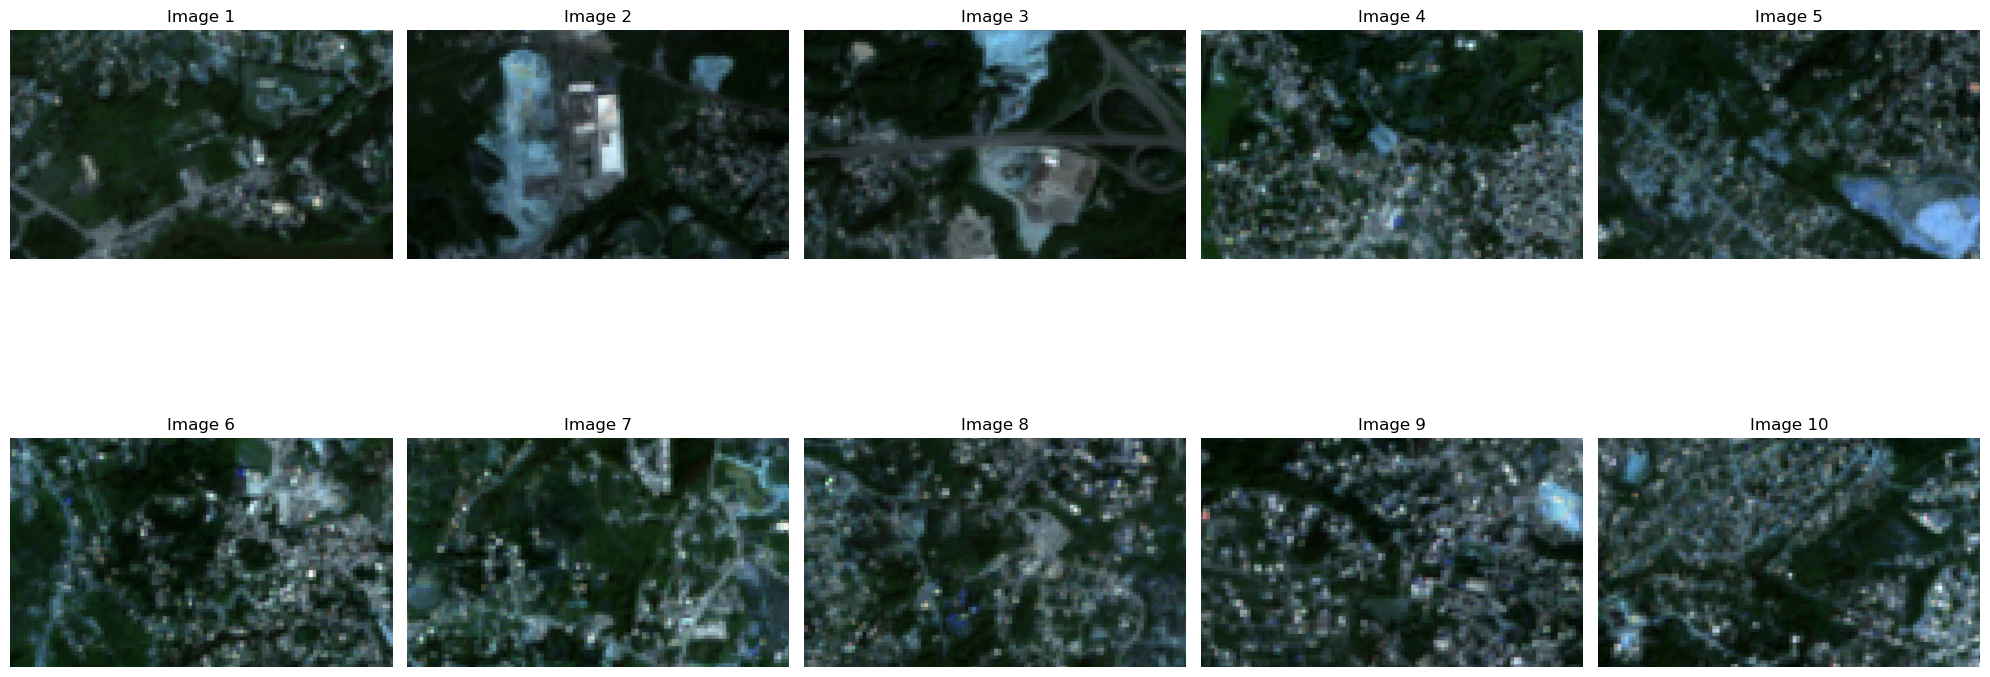

In [71]:
# Show the images in image_list_testing
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(image_list[i-1])
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [72]:
df_effnet_features = fe.extract(effnet, effnet_p, image_list, (662, 1103, 3))

 2/29 ━━━━━━━━━━━━━━━━━━━━ 1:02:18 138s/step

In [ ]:
# Save df_features to a csv file
df_effnet_features.to_csv(os.path.join("output", "img_effnet7_features.csv"), index=True)

In [ ]:
df_effnet_features.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1740790,1740791,1740792,1740793,1740794,1740795,1740796,1740797,1740798,1740799
0,1.016929,0.841449,-0.257669,3.980330,0.385360,0.181312,1.938499,0.967057,2.694891,4.021260,...,1.108833,0.031617,3.833739,2.587960,4.874409,1.272705,2.935827,0.783007,4.132522,3.200315
1,0.112824,0.464785,0.341689,2.409966,-0.272466,0.164352,0.800335,0.023763,1.754412,3.747551,...,0.124834,-0.252080,1.754502,1.424754,3.863269,0.473172,1.927006,0.226815,1.795825,1.698789
2,3.294052,2.740209,1.451117,3.475866,1.073636,4.127676,5.027627,2.636917,4.097660,4.350849,...,2.533631,1.079999,6.038784,4.228315,6.216557,1.627518,4.743045,1.343001,4.919577,4.150798
3,0.757487,1.348207,1.393013,4.031858,-0.001127,1.108615,1.054524,1.477241,4.194519,5.325559,...,3.406082,2.198465,7.225193,5.672869,6.735966,3.396398,5.047409,2.663379,7.114786,5.524702
4,1.691160,0.355206,1.833481,2.997610,0.893547,1.885972,3.870863,0.813082,2.898832,4.682374,...,3.924301,3.315610,8.172237,6.081489,8.142148,4.024102,6.630347,2.881696,7.581090,6.069518
5,3.113816,1.167020,1.853904,3.373088,0.978011,2.255177,3.569389,1.981347,2.857475,4.833051,...,1.959258,0.517127,6.747830,4.261288,6.723415,1.729792,3.727377,1.318050,5.699098,4.538935
6,2.321243,1.654670,2.669268,4.192903,1.203386,2.428202,4.708137,2.000906,3.400212,5.600311,...,3.047245,1.123687,7.417430,4.931717,7.744590,2.186760,5.734391,2.268907,6.748971,4.864311
7,1.924612,0.257560,0.835280,3.094353,0.780886,1.149441,3.144031,1.468495,2.729001,4.356969,...,2.899969,2.233931,6.842618,5.696024,6.812272,3.633383,4.969862,2.180404,6.725297,5.690572
8,2.189646,0.321105,1.995460,3.165679,0.478870,1.919152,3.552820,1.112976,3.006464,4.693391,...,2.967340,1.083862,7.746135,5.214872,7.308918,2.293618,5.648664,2.288270,7.004604,5.481541


In [ ]:
# Use PCA to reduce the dimensionality of the features
from sklearn.decomposition import PCA

pca = PCA(n_components="mle", random_state=SEED) # Minka's MLE to guess dimensionality
pca.fit(df_effnet_features)

# Transform the features
df_effnet_features_pca = pd.DataFrame(pca.transform(df_effnet_features), index=df_effnet_features.index)